# Layer-Level 相似度分析（GSM8K 数据集）

本 notebook 使用 GSM8K 数据集分析 LLaDA 模型中相邻层之间的 hidden states 余弦相似度。

**分析目标：**
1. 相邻层输出之间的余弦相似度分布
2. 每一层的输入-输出相似度（层的"改变程度"）
3. 不同 token 位置的相似度差异（prompt vs generated）
4. 不同 denoising step 的相似度变化
5. 跨多个 prompt 的统计分析

**数据集：** GSM8K (20 samples, seed=42)

## 1. 环境设置

In [1]:
import os
import torch
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
from tqdm import tqdm

# 设置 GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 切换到 llada 目录
os.chdir('llada')

torch.cuda.empty_cache()
gc.collect()

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 固定随机种子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Random seed: {SEED}")

CUDA available: True
GPU: NVIDIA GeForce RTX 3090 Ti
Random seed: 42


## 2. 加载模型

In [2]:
from transformers import AutoTokenizer
from model.modeling_llada import LLaDAModelLM

device = 'cuda'
model_name = 'GSAI-ML/LLaDA-8B-Instruct'

print(f"Loading model: {model_name}")
model = LLaDAModelLM.from_pretrained(
    model_name, 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16
).to(device).eval()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

n_layers = model.model.config.n_layers
d_model = model.model.config.d_model

print(f"✅ Model loaded!")
print(f"   Layers: {n_layers}")
print(f"   Hidden dim: {d_model}")

/home/pianng/miniconda3/envs/dllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading model: GSAI-ML/LLaDA-8B-Instruct


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  7.27it/s]


✅ Model loaded!
   Layers: 32
   Hidden dim: 4096


In [3]:
from generate import (
    generate_with_dual_cache_hooked,
    LayerHiddenStatesCollector,
)
import torch.nn.functional as F

print("✅ Functions imported!")

✅ Functions imported!


## 3. 加载 GSM8K 数据集

In [4]:
from datasets import load_dataset

# 加载 GSM8K 数据集
print("Loading GSM8K dataset...")
gsm8k = load_dataset("gsm8k", "main", split="test")

print(f"Total samples: {len(gsm8k)}")

# 随机抽取 20 个样本
NUM_SAMPLES = 20
indices = list(range(len(gsm8k)))
random.shuffle(indices)
selected_indices = indices[:NUM_SAMPLES]

gsm8k_samples = [gsm8k[i] for i in selected_indices]

print(f"\nSelected {NUM_SAMPLES} samples (seed={SEED})")
print(f"Sample indices: {selected_indices}")

Loading GSM8K dataset...


Generating test split: 100%|██████████| 1319/1319 [00:00<00:00, 479941.61 examples/s]

Total samples: 1319

Selected 20 samples (seed=42)
Sample indices: [588, 1214, 57, 906, 1252, 618, 599, 289, 608, 400, 237, 616, 672, 1132, 463, 222, 945, 238, 730, 55]


In [5]:
# 查看样本示例
print("Sample questions:")
print("=" * 60)
for i, sample in enumerate(gsm8k_samples[:3]):
    print(f"\n[{i+1}] {sample['question'][:100]}...")
    print(f"    Answer: {sample['answer'].split('####')[-1].strip()}")

Sample questions:

[1] Jared is trying to increase his typing speed. He starts with 47 words per minute (WPM). After some l...
    Answer: 52

[2] Jordan has 2 children who wear diapers.  Each child requires 5 diaper changes per day.  Jordan's wif...
    Answer: 5

[3] A wooden bridge can carry no more than 5000 pounds. A delivery truck filled with identical boxes, ea...
    Answer: 83


## 4. 工具函数

In [6]:
def prepare_input(prompt_text, tokenizer, device):
    """准备输入 tensor"""
    m = [{"role": "user", "content": prompt_text}]
    prompt = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
    input_ids = tokenizer(prompt)['input_ids']
    input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)
    return input_ids


def compute_per_token_cosine_similarity(tensor1, tensor2):
    """
    计算两个 tensor 在每个 token 位置的余弦相似度。
    
    Args:
        tensor1, tensor2: (B, L, D) 的 tensor
    
    Returns:
        (B, L) 的相似度 tensor
    """
    norm1 = F.normalize(tensor1.float(), p=2, dim=-1)
    norm2 = F.normalize(tensor2.float(), p=2, dim=-1)
    cos_sim = (norm1 * norm2).sum(dim=-1)
    return cos_sim


def compute_layer_change_magnitude(input_tensor, output_tensor):
    """
    计算层的变化幅度（相对 L2 范数）。
    """
    diff = (output_tensor.float() - input_tensor.float())
    # 相对变化：diff_norm / input_norm
    input_norm = input_tensor.float().norm(p=2, dim=-1).mean().item()
    diff_norm = diff.norm(p=2, dim=-1).mean().item()
    return diff_norm, diff_norm / (input_norm + 1e-8)

## 5. 收集所有样本的 Layer 相似度数据

In [7]:
# 生成参数
GEN_PARAMS = {
    'steps': 64,
    'gen_length': 128,
    'block_length': 32,
    'temperature': 0.,
    'threshold': 0.9,
}

# 存储所有样本的数据
all_adjacent_similarities = defaultdict(list)  # {layer_pair: [similarities across samples]}
all_io_similarities = defaultdict(list)        # {layer: [similarities across samples]}
all_io_magnitudes = defaultdict(list)          # {layer: [magnitudes across samples]}
all_io_rel_magnitudes = defaultdict(list)      # {layer: [relative magnitudes across samples]}

sample_results = []  # 存储每个样本的详细结果

print(f"Processing {NUM_SAMPLES} GSM8K samples...")
print(f"Generation params: {GEN_PARAMS}")
print("=" * 60)

for idx, sample in enumerate(tqdm(gsm8k_samples, desc="Analyzing samples")):
    question = sample['question']
    input_ids = prepare_input(question, tokenizer, device)
    prompt_len = input_ids.shape[1]
    
    # 创建 collector 并注册 hooks
    collector = LayerHiddenStatesCollector()
    collector.register_hooks(model)
    
    # 运行生成
    x, nfe, _ = generate_with_dual_cache_hooked(
        model, input_ids, 
        collector=collector, 
        collect_per_step=False,
        **GEN_PARAMS
    )
    
    # 获取 hidden states
    layer_data = collector.get_layer_hidden_states()
    
    # 解码答案
    answer = tokenizer.decode(x[0, prompt_len:], skip_special_tokens=True)
    
    # 计算相邻层相似度
    sample_adj_sims = {}
    for i in range(n_layers - 1):
        if i in layer_data['outputs'] and (i+1) in layer_data['outputs']:
            cos_sim = compute_per_token_cosine_similarity(
                layer_data['outputs'][i], layer_data['outputs'][i+1]
            )
            mean_sim = cos_sim.mean().item()
            all_adjacent_similarities[i].append(mean_sim)
            sample_adj_sims[i] = mean_sim
    
    # 计算输入-输出相似度
    sample_io_sims = {}
    sample_io_mags = {}
    for i in range(n_layers):
        if i in layer_data['inputs'] and i in layer_data['outputs']:
            cos_sim = compute_per_token_cosine_similarity(
                layer_data['inputs'][i], layer_data['outputs'][i]
            )
            mean_sim = cos_sim.mean().item()
            all_io_similarities[i].append(mean_sim)
            sample_io_sims[i] = mean_sim
            
            # 变化幅度
            mag, rel_mag = compute_layer_change_magnitude(
                layer_data['inputs'][i], layer_data['outputs'][i]
            )
            all_io_magnitudes[i].append(mag)
            all_io_rel_magnitudes[i].append(rel_mag)
            sample_io_mags[i] = (mag, rel_mag)
    
    # 存储结果
    sample_results.append({
        'idx': idx,
        'question': question[:50] + '...',
        'prompt_len': prompt_len,
        'nfe': nfe,
        'answer': answer[:50] + '...',
        'adj_sims': sample_adj_sims,
        'io_sims': sample_io_sims,
        'io_mags': sample_io_mags,
    })
    
    collector.remove_hooks()

print(f"\n✅ Processed {len(sample_results)} samples")

Processing 20 GSM8K samples...
Generation params: {'steps': 64, 'gen_length': 128, 'block_length': 32, 'temperature': 0.0, 'threshold': 0.9}


Analyzing samples: 100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


✅ Processed 20 samples


## 6. 统计分析：相邻层输出相似度

In [8]:
import pandas as pd

# 汇总统计
adj_stats = []
for i in sorted(all_adjacent_similarities.keys()):
    sims = all_adjacent_similarities[i]
    adj_stats.append({
        'Layer Pair': f"{i}->{i+1}",
        'Mean': np.mean(sims),
        'Std': np.std(sims),
        'Min': np.min(sims),
        'Max': np.max(sims),
        'Median': np.median(sims),
        '>0.99': np.mean(np.array(sims) > 0.99) * 100,
        '>0.95': np.mean(np.array(sims) > 0.95) * 100,
    })

df_adj = pd.DataFrame(adj_stats)
print("相邻层输出余弦相似度统计（N={} samples）:".format(NUM_SAMPLES))
display(df_adj.style.format({
    'Mean': '{:.4f}', 'Std': '{:.4f}', 'Min': '{:.4f}', 
    'Max': '{:.4f}', 'Median': '{:.4f}', '>0.99': '{:.1f}%', '>0.95': '{:.1f}%'
}).background_gradient(subset=['Mean'], cmap='RdYlGn', vmin=0.9, vmax=1.0))

相邻层输出余弦相似度统计（N=20 samples）:


,Layer Pair,Mean,Std,Min,Max,Median,>0.99,>0.95
0,0->1,0.9822,0.0024,0.9776,0.9878,0.9823,0.0%,100.0%
1,1->2,0.9890,0.0026,0.9836,0.9971,0.9886,10.0%,100.0%
2,2->3,0.9878,0.0013,0.9842,0.9901,0.9877,5.0%,100.0%
3,3->4,0.9897,0.0015,0.9868,0.9938,0.9894,25.0%,100.0%
4,4->5,0.9894,0.0020,0.9864,0.9953,0.9892,15.0%,100.0%
5,5->6,0.9892,0.0011,0.9872,0.9911,0.9892,20.0%,100.0%
6,6->7,0.9903,0.0012,0.9884,0.9932,0.9900,55.0%,100.0%
7,7->8,0.9897,0.0009,0.9879,0.9918,0.9897,30.0%,100.0%
8,8->9,0.9884,0.0011,0.9860,0.9908,0.9884,5.0%,100.0%
9,9->10,0.9837,0.0027,0.9773,0.9897,0.9836,0.0%,100.0%


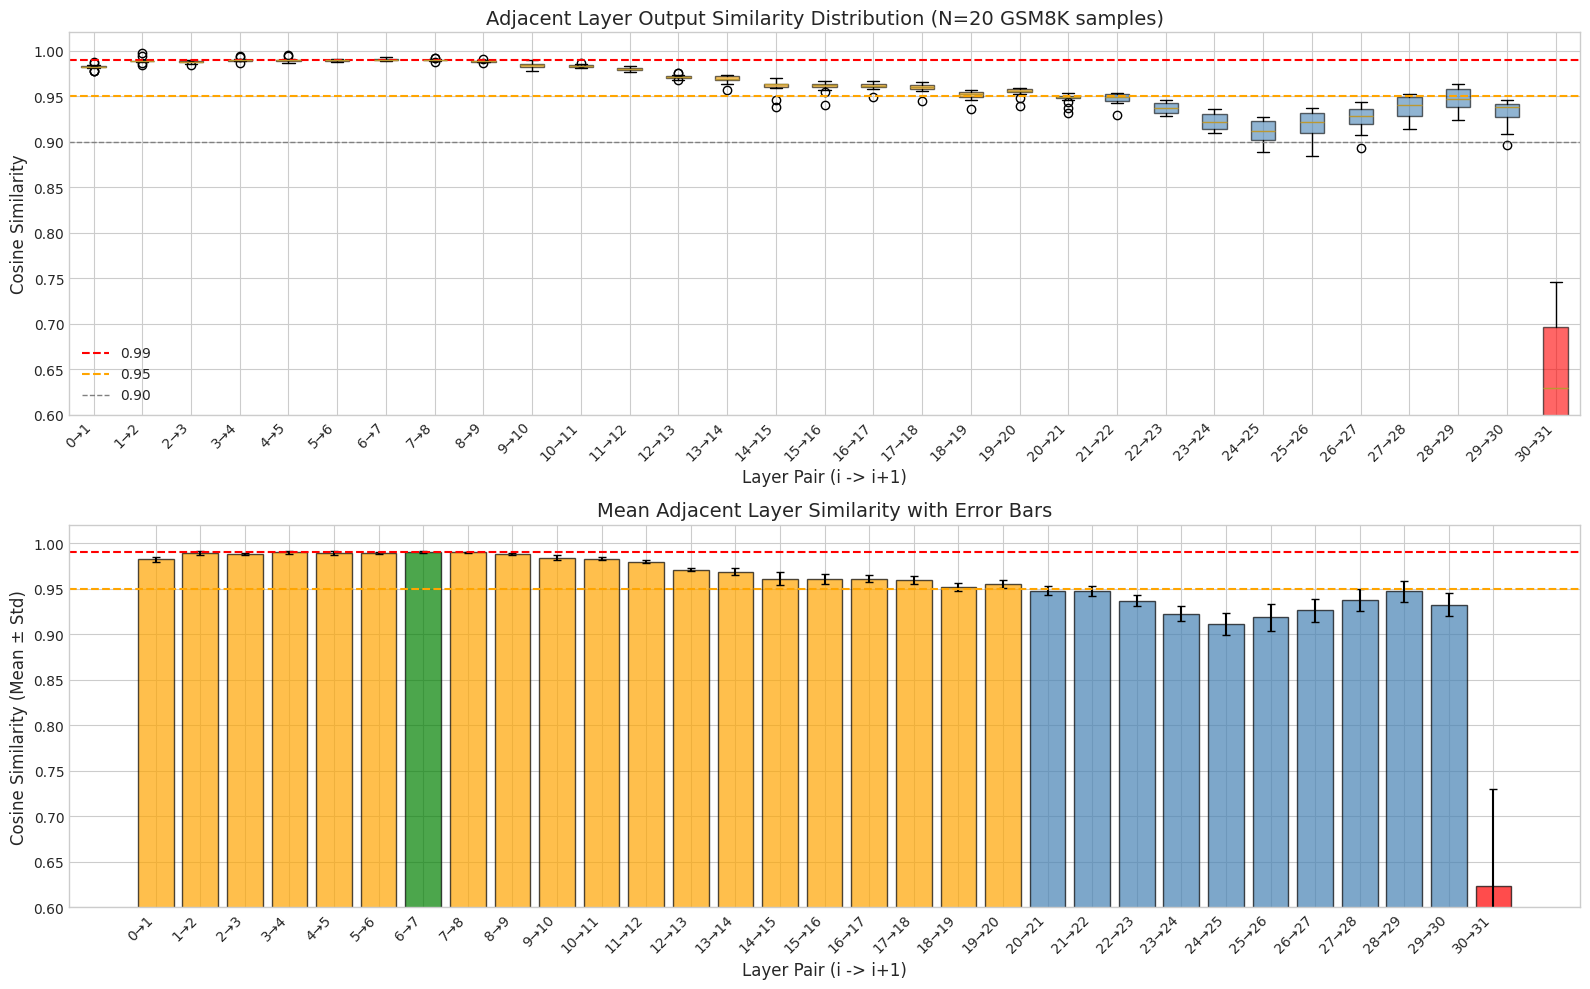

Saved: adjacent_layer_similarity.png


In [9]:
# 可视化相邻层相似度分布
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 上图：箱线图
ax1 = axes[0]
adj_data = [all_adjacent_similarities[i] for i in sorted(all_adjacent_similarities.keys())]
bp = ax1.boxplot(adj_data, patch_artist=True)

# 根据中位数着色
colors = []
for i, data in enumerate(adj_data):
    median = np.median(data)
    if median > 0.99:
        colors.append('green')
    elif median > 0.95:
        colors.append('orange')
    elif median > 0.90:
        colors.append('steelblue')
    else:
        colors.append('red')

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax1.set_xlabel('Layer Pair (i -> i+1)', fontsize=12)
ax1.set_ylabel('Cosine Similarity', fontsize=12)
ax1.set_title(f'Adjacent Layer Output Similarity Distribution (N={NUM_SAMPLES} GSM8K samples)', fontsize=14)
ax1.set_xticklabels([f"{i}→{i+1}" for i in range(n_layers-1)], rotation=45, ha='right')
ax1.axhline(y=0.99, color='red', linestyle='--', linewidth=1.5, label='0.99')
ax1.axhline(y=0.95, color='orange', linestyle='--', linewidth=1.5, label='0.95')
ax1.axhline(y=0.90, color='gray', linestyle='--', linewidth=1, label='0.90')
ax1.legend(loc='lower left')
ax1.set_ylim(0.6, 1.02)

# 下图：均值+标准差
ax2 = axes[1]
means = [np.mean(d) for d in adj_data]
stds = [np.std(d) for d in adj_data]
x_pos = range(len(means))

ax2.bar(x_pos, means, yerr=stds, capsize=3, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Layer Pair (i -> i+1)', fontsize=12)
ax2.set_ylabel('Cosine Similarity (Mean ± Std)', fontsize=12)
ax2.set_title('Mean Adjacent Layer Similarity with Error Bars', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{i}→{i+1}" for i in range(n_layers-1)], rotation=45, ha='right')
ax2.axhline(y=0.99, color='red', linestyle='--', linewidth=1.5)
ax2.axhline(y=0.95, color='orange', linestyle='--', linewidth=1.5)
ax2.set_ylim(0.6, 1.02)

plt.tight_layout()
plt.savefig('adjacent_layer_similarity.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: adjacent_layer_similarity.png")

## 7. 统计分析：每层输入-输出相似度

In [10]:
# 汇总统计
io_stats = []
for i in sorted(all_io_similarities.keys()):
    sims = all_io_similarities[i]
    mags = all_io_magnitudes[i]
    rel_mags = all_io_rel_magnitudes[i]
    io_stats.append({
        'Layer': i,
        'I/O Sim Mean': np.mean(sims),
        'I/O Sim Std': np.std(sims),
        'Change Mag': np.mean(mags),
        'Rel Change': np.mean(rel_mags),
        '>0.99': np.mean(np.array(sims) > 0.99) * 100,
    })

df_io = pd.DataFrame(io_stats)
print("每层输入-输出相似度统计（N={} samples）:".format(NUM_SAMPLES))
display(df_io.style.format({
    'I/O Sim Mean': '{:.4f}', 'I/O Sim Std': '{:.4f}', 
    'Change Mag': '{:.2f}', 'Rel Change': '{:.4f}', '>0.99': '{:.1f}%'
}).background_gradient(subset=['I/O Sim Mean'], cmap='RdYlGn', vmin=0.9, vmax=1.0))

每层输入-输出相似度统计（N=20 samples）:


,Layer,I/O Sim Mean,I/O Sim Std,Change Mag,Rel Change,>0.99
0,0,0.2674,0.0200,29.53,3.0875,0.0%
1,1,0.9822,0.0024,8.63,0.2812,0.0%
2,2,0.9890,0.0026,7.64,0.2109,10.0%
3,3,0.9878,0.0013,10.79,0.2575,5.0%
4,4,0.9897,0.0015,10.04,0.2012,25.0%
5,5,0.9894,0.0020,10.76,0.1901,15.0%
6,6,0.9892,0.0011,12.23,0.1926,20.0%
7,7,0.9903,0.0012,11.48,0.1633,55.0%
8,8,0.9897,0.0009,11.43,0.1505,30.0%
9,9,0.9884,0.0011,13.06,0.1636,5.0%


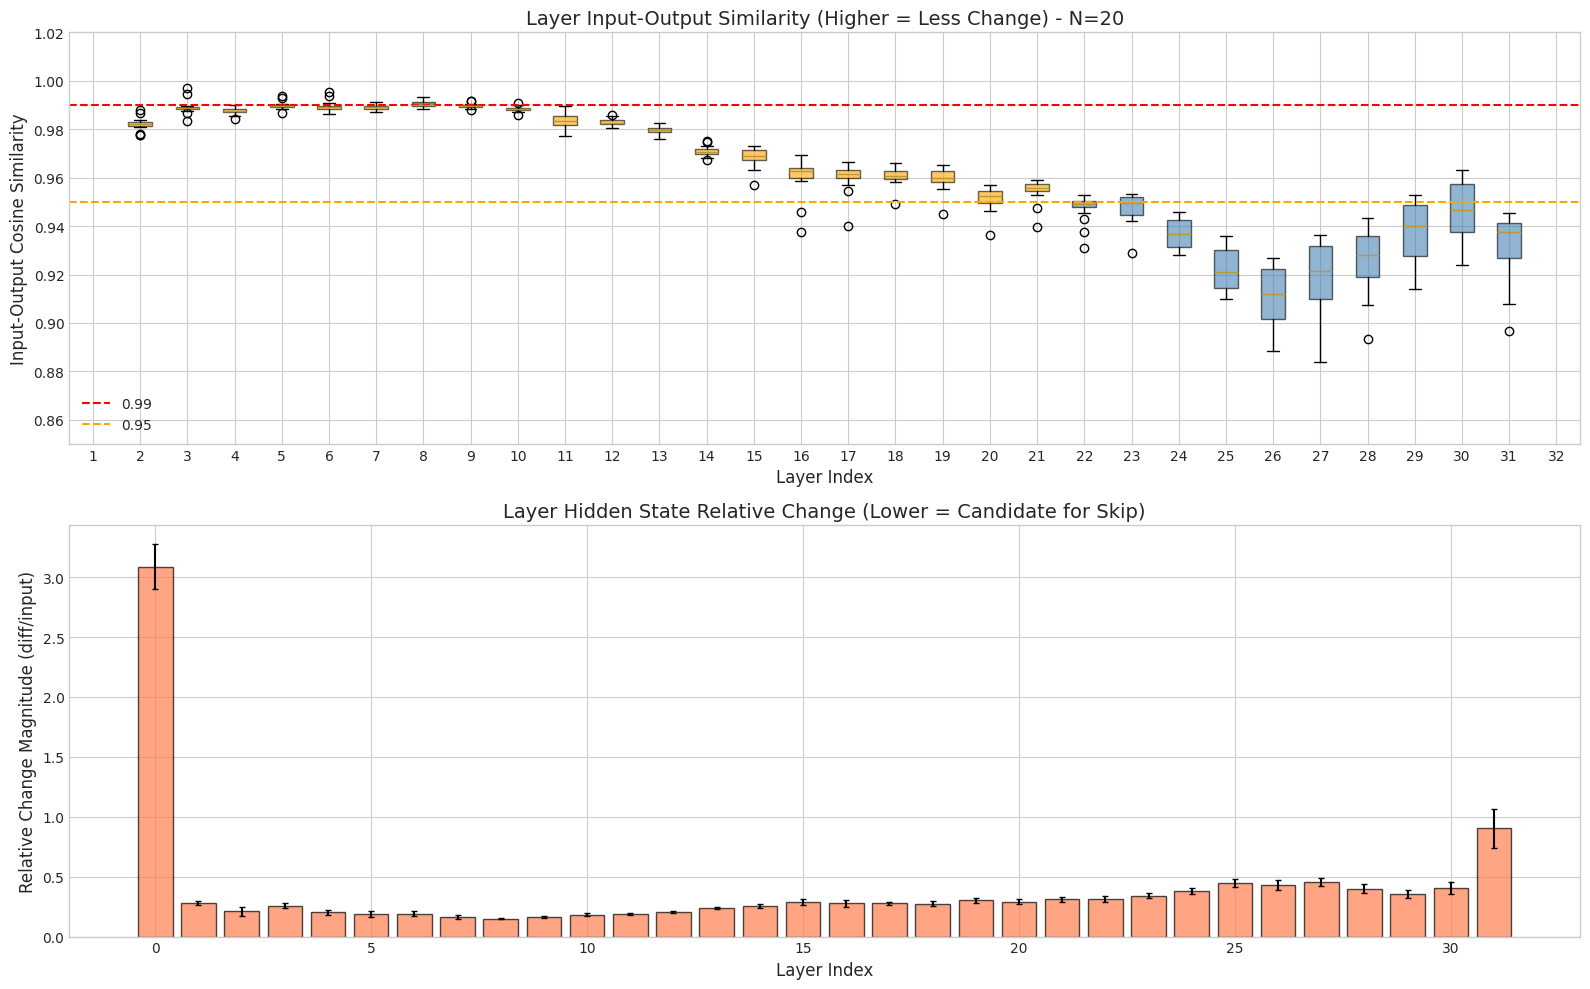

Saved: layer_io_similarity.png


In [11]:
# 可视化输入-输出相似度
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 上图：输入-输出相似度箱线图
ax1 = axes[0]
io_data = [all_io_similarities[i] for i in sorted(all_io_similarities.keys())]
bp = ax1.boxplot(io_data, patch_artist=True)

colors = []
for data in io_data:
    median = np.median(data)
    if median > 0.99:
        colors.append('green')
    elif median > 0.95:
        colors.append('orange')
    elif median > 0.90:
        colors.append('steelblue')
    else:
        colors.append('red')

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax1.set_xlabel('Layer Index', fontsize=12)
ax1.set_ylabel('Input-Output Cosine Similarity', fontsize=12)
ax1.set_title(f'Layer Input-Output Similarity (Higher = Less Change) - N={NUM_SAMPLES}', fontsize=14)
ax1.axhline(y=0.99, color='red', linestyle='--', linewidth=1.5, label='0.99')
ax1.axhline(y=0.95, color='orange', linestyle='--', linewidth=1.5, label='0.95')
ax1.legend(loc='lower left')
ax1.set_ylim(0.85, 1.02)

# 下图：变化幅度
ax2 = axes[1]
rel_mag_means = [np.mean(all_io_rel_magnitudes[i]) for i in sorted(all_io_rel_magnitudes.keys())]
rel_mag_stds = [np.std(all_io_rel_magnitudes[i]) for i in sorted(all_io_rel_magnitudes.keys())]

ax2.bar(range(n_layers), rel_mag_means, yerr=rel_mag_stds, capsize=2, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Layer Index', fontsize=12)
ax2.set_ylabel('Relative Change Magnitude (diff/input)', fontsize=12)
ax2.set_title('Layer Hidden State Relative Change (Lower = Candidate for Skip)', fontsize=14)

plt.tight_layout()
plt.savefig('layer_io_similarity.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: layer_io_similarity.png")

## 8. 热力图：Sample x Layer 相似度矩阵

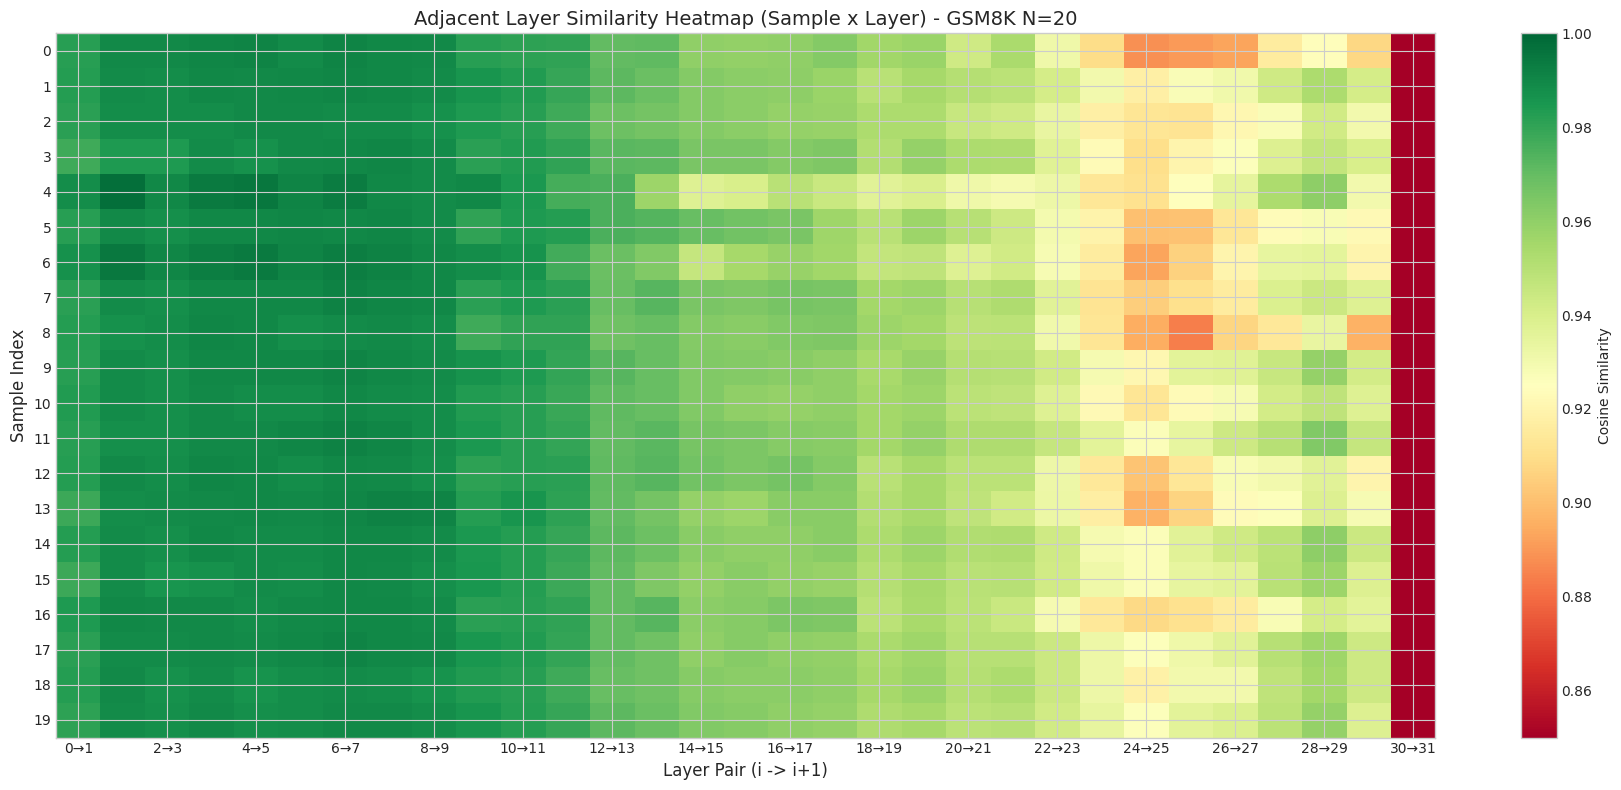


相似度统计:
   高相似度 (>0.99): 33/620 = 5.3%
   中高相似度 (>0.95): 413/620 = 66.6%
   中等相似度 (>0.90): 592/620 = 95.5%


In [12]:
# 构建相邻层相似度矩阵 (n_samples, n_layers-1)
adj_sim_matrix = np.zeros((NUM_SAMPLES, n_layers - 1))

for sample_idx, result in enumerate(sample_results):
    for layer_idx in range(n_layers - 1):
        if layer_idx in result['adj_sims']:
            adj_sim_matrix[sample_idx, layer_idx] = result['adj_sims'][layer_idx]

# 绘制热力图
fig, ax = plt.subplots(figsize=(18, 8))

im = ax.imshow(adj_sim_matrix, aspect='auto', cmap='RdYlGn', vmin=0.85, vmax=1.0)
ax.set_xlabel('Layer Pair (i -> i+1)', fontsize=12)
ax.set_ylabel('Sample Index', fontsize=12)
ax.set_title(f'Adjacent Layer Similarity Heatmap (Sample x Layer) - GSM8K N={NUM_SAMPLES}', fontsize=14)

# 设置刻度
ax.set_xticks(range(0, n_layers - 1, 2))
ax.set_xticklabels([f"{i}→{i+1}" for i in range(0, n_layers - 1, 2)])
ax.set_yticks(range(NUM_SAMPLES))

cbar = plt.colorbar(im, label='Cosine Similarity')

plt.tight_layout()
plt.savefig('similarity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# 统计
print(f"\n相似度统计:")
print(f"   高相似度 (>0.99): {(adj_sim_matrix > 0.99).sum()}/{adj_sim_matrix.size} = {(adj_sim_matrix > 0.99).mean()*100:.1f}%")
print(f"   中高相似度 (>0.95): {(adj_sim_matrix > 0.95).sum()}/{adj_sim_matrix.size} = {(adj_sim_matrix > 0.95).mean()*100:.1f}%")
print(f"   中等相似度 (>0.90): {(adj_sim_matrix > 0.90).sum()}/{adj_sim_matrix.size} = {(adj_sim_matrix > 0.90).mean()*100:.1f}%")

## 9. 层聚类分析

In [13]:
# 基于相似度特征对层进行分组
print("基于相邻层相似度的层分组分析:")
print("=" * 60)

# 计算每个层对的平均相似度
layer_pair_means = {i: np.mean(all_adjacent_similarities[i]) for i in sorted(all_adjacent_similarities.keys())}

# 分组
very_high = [(i, m) for i, m in layer_pair_means.items() if m > 0.99]
high = [(i, m) for i, m in layer_pair_means.items() if 0.95 < m <= 0.99]
medium = [(i, m) for i, m in layer_pair_means.items() if 0.90 < m <= 0.95]
low = [(i, m) for i, m in layer_pair_means.items() if m <= 0.90]

print(f"\n🟢 极高相似度 (>0.99) - 强烈建议跳过候选:")
if very_high:
    for i, m in very_high:
        print(f"   Layer {i} -> {i+1}: {m:.4f}")
else:
    print("   无")

print(f"\n🟡 高相似度 (0.95-0.99) - 可考虑跳过:")
if high:
    for i, m in high:
        print(f"   Layer {i} -> {i+1}: {m:.4f}")
else:
    print("   无")

print(f"\n🔵 中等相似度 (0.90-0.95) - 需谨慎:")
if medium:
    for i, m in medium:
        print(f"   Layer {i} -> {i+1}: {m:.4f}")
else:
    print("   无")

print(f"\n🔴 低相似度 (<0.90) - 不建议跳过:")
if low:
    for i, m in low:
        print(f"   Layer {i} -> {i+1}: {m:.4f}")
else:
    print("   无")

基于相邻层相似度的层分组分析:

🟢 极高相似度 (>0.99) - 强烈建议跳过候选:
   Layer 6 -> 7: 0.9903

🟡 高相似度 (0.95-0.99) - 可考虑跳过:
   Layer 0 -> 1: 0.9822
   Layer 1 -> 2: 0.9890
   Layer 2 -> 3: 0.9878
   Layer 3 -> 4: 0.9897
   Layer 4 -> 5: 0.9894
   Layer 5 -> 6: 0.9892
   Layer 7 -> 8: 0.9897
   Layer 8 -> 9: 0.9884
   Layer 9 -> 10: 0.9837
   Layer 10 -> 11: 0.9830
   Layer 11 -> 12: 0.9795
   Layer 12 -> 13: 0.9708
   Layer 13 -> 14: 0.9686
   Layer 14 -> 15: 0.9608
   Layer 15 -> 16: 0.9605
   Layer 16 -> 17: 0.9609
   Layer 17 -> 18: 0.9598
   Layer 18 -> 19: 0.9515
   Layer 19 -> 20: 0.9549

🔵 中等相似度 (0.90-0.95) - 需谨慎:
   Layer 20 -> 21: 0.9477
   Layer 21 -> 22: 0.9476
   Layer 22 -> 23: 0.9367
   Layer 23 -> 24: 0.9222
   Layer 24 -> 25: 0.9113
   Layer 25 -> 26: 0.9184
   Layer 26 -> 27: 0.9262
   Layer 27 -> 28: 0.9376
   Layer 28 -> 29: 0.9469
   Layer 29 -> 30: 0.9321

🔴 低相似度 (<0.90) - 不建议跳过:
   Layer 30 -> 31: 0.6234


## 10. 潜在 Skip 收益分析

In [14]:
# 分析如果跳过某些层，潜在的计算节省
print("潜在 Layer Skip 收益分析:")
print("=" * 60)

# 基于不同阈值的跳过策略
thresholds = [0.99, 0.98, 0.97, 0.95]

for thresh in thresholds:
    # 对于每个样本，统计有多少层对超过阈值
    skip_counts = []
    for result in sample_results:
        count = sum(1 for sim in result['adj_sims'].values() if sim > thresh)
        skip_counts.append(count)
    
    mean_skip = np.mean(skip_counts)
    std_skip = np.std(skip_counts)
    potential_saving = mean_skip / (n_layers - 1) * 100
    
    print(f"\n阈值 {thresh}:")
    print(f"   平均可跳过层对数: {mean_skip:.1f} ± {std_skip:.1f} / {n_layers-1}")
    print(f"   潜在计算节省: {potential_saving:.1f}%")

潜在 Layer Skip 收益分析:

阈值 0.99:
   平均可跳过层对数: 1.6 ± 1.9 / 31
   潜在计算节省: 5.3%

阈值 0.98:
   平均可跳过层对数: 11.2 ± 0.5 / 31
   潜在计算节省: 36.1%

阈值 0.97:
   平均可跳过层对数: 13.1 ± 0.7 / 31
   潜在计算节省: 42.3%

阈值 0.95:
   平均可跳过层对数: 20.6 ± 2.0 / 31
   潜在计算节省: 66.6%


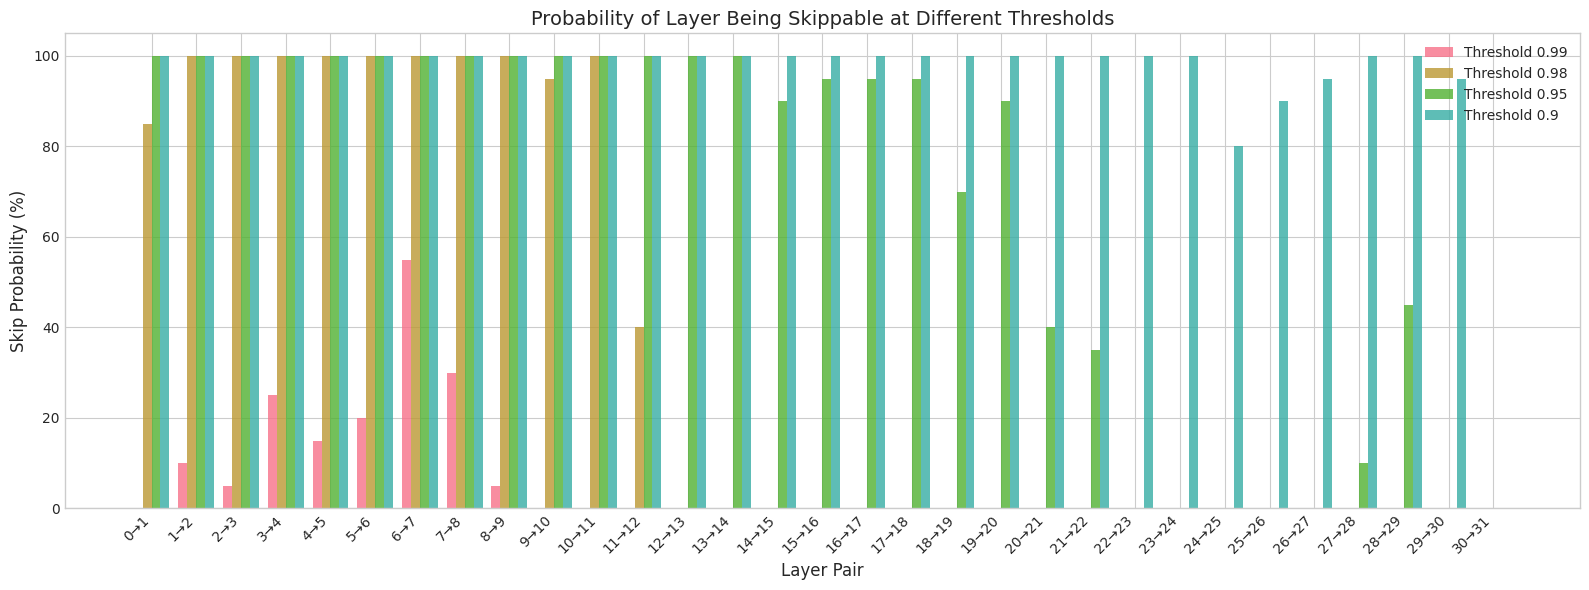

Saved: skip_probability.png


In [15]:
# 可视化：不同阈值下各层被跳过的概率
fig, ax = plt.subplots(figsize=(16, 6))

thresholds = [0.99, 0.98, 0.95, 0.90]
width = 0.2
x = np.arange(n_layers - 1)

for idx, thresh in enumerate(thresholds):
    skip_probs = []
    for layer_idx in range(n_layers - 1):
        sims = all_adjacent_similarities[layer_idx]
        prob = np.mean(np.array(sims) > thresh)
        skip_probs.append(prob * 100)
    
    ax.bar(x + idx * width, skip_probs, width, label=f'Threshold {thresh}', alpha=0.8)

ax.set_xlabel('Layer Pair', fontsize=12)
ax.set_ylabel('Skip Probability (%)', fontsize=12)
ax.set_title('Probability of Layer Being Skippable at Different Thresholds', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([f"{i}→{i+1}" for i in range(n_layers-1)], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('skip_probability.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: skip_probability.png")

## 11. 总结报告

In [16]:
print("\n" + "=" * 70)
print("                     Layer-Level 相似度分析总结报告")
print("=" * 70)

print(f"\n📊 数据集: GSM8K, {NUM_SAMPLES} samples (seed={SEED})")
print(f"📊 模型: {model_name}")
print(f"📊 层数: {n_layers}")

# 关键发现
print(f"\n{'='*70}")
print("关键发现")
print(f"{'='*70}")

# 1. 相邻层相似度趋势
layer_means = [np.mean(all_adjacent_similarities[i]) for i in range(n_layers-1)]
early_layers_sim = np.mean(layer_means[:8])
mid_layers_sim = np.mean(layer_means[8:20])
late_layers_sim = np.mean(layer_means[20:])

print(f"\n1. 相邻层输出相似度趋势:")
print(f"   浅层 (0-7):   {early_layers_sim:.4f}")
print(f"   中层 (8-19):  {mid_layers_sim:.4f}")
print(f"   深层 (20-31): {late_layers_sim:.4f}")

# 2. 最高和最低相似度层
max_layer = np.argmax(layer_means)
min_layer = np.argmin(layer_means)
print(f"\n2. 极值分析:")
print(f"   最高相似度: Layer {max_layer}->{max_layer+1} = {layer_means[max_layer]:.4f}")
print(f"   最低相似度: Layer {min_layer}->{min_layer+1} = {layer_means[min_layer]:.4f}")

# 3. Skip 策略建议
print(f"\n3. Layer Skip 策略建议:")

safe_skip_layers = [i for i, m in enumerate(layer_means) if m > 0.98]
risky_skip_layers = [i for i, m in enumerate(layer_means) if m < 0.92]

if safe_skip_layers:
    print(f"   ✅ 安全跳过候选 (sim>0.98): Layers {safe_skip_layers}")
else:
    print(f"   ✅ 安全跳过候选 (sim>0.98): 无")

if risky_skip_layers:
    print(f"   ⚠️  风险层 (sim<0.92): Layers {risky_skip_layers}")
else:
    print(f"   ⚠️  风险层 (sim<0.92): 无")

# 4. 实现建议
print(f"\n{'='*70}")
print("实现建议")
print(f"{'='*70}")
print("""
1. 阈值选择:
   - 保守: 0.99 (仅跳过极高相似度层)
   - 平衡: 0.97-0.98
   - 激进: 0.95 (更多跳过但有质量风险)

2. 动态跳过策略:
   - 在每个 denoising step 计算当前层与前一层的相似度
   - 如果 sim > threshold，复用前一层的 hidden states
   - 需要同步更新 KV cache

3. 注意事项:
   - 最后几层 (30->31) 相似度通常较低，不建议跳过
   - 浅层相似度较高，但跳过收益也较低
   - 建议从中间层开始尝试跳过
""")


                     Layer-Level 相似度分析总结报告

📊 数据集: GSM8K, 20 samples (seed=42)
📊 模型: GSAI-ML/LLaDA-8B-Instruct
📊 层数: 32

关键发现

1. 相邻层输出相似度趋势:
   浅层 (0-7):   0.9884
   中层 (8-19):  0.9685
   深层 (20-31): 0.9046

2. 极值分析:
   最高相似度: Layer 6->7 = 0.9903
   最低相似度: Layer 30->31 = 0.6234

3. Layer Skip 策略建议:
   ✅ 安全跳过候选 (sim>0.98): Layers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
   ⚠️  风险层 (sim<0.92): Layers [24, 25, 30]

实现建议

1. 阈值选择:
   - 保守: 0.99 (仅跳过极高相似度层)
   - 平衡: 0.97-0.98
   - 激进: 0.95 (更多跳过但有质量风险)

2. 动态跳过策略:
   - 在每个 denoising step 计算当前层与前一层的相似度
   - 如果 sim > threshold，复用前一层的 hidden states
   - 需要同步更新 KV cache

3. 注意事项:
   - 最后几层 (30->31) 相似度通常较低，不建议跳过
   - 浅层相似度较高，但跳过收益也较低
   - 建议从中间层开始尝试跳过



## 12. 保存数据供后续分析

In [17]:
import json

# 保存统计数据
analysis_results = {
    'config': {
        'model': model_name,
        'n_layers': n_layers,
        'n_samples': NUM_SAMPLES,
        'seed': SEED,
        'gen_params': GEN_PARAMS,
    },
    'adjacent_similarities': {
        str(k): {'mean': float(np.mean(v)), 'std': float(np.std(v)), 'values': [float(x) for x in v]}
        for k, v in all_adjacent_similarities.items()
    },
    'io_similarities': {
        str(k): {'mean': float(np.mean(v)), 'std': float(np.std(v)), 'values': [float(x) for x in v]}
        for k, v in all_io_similarities.items()
    },
}

with open('layer_similarity_analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

print("✅ 分析结果已保存到: layer_similarity_analysis_results.json")

✅ 分析结果已保存到: layer_similarity_analysis_results.json
